<a href="https://colab.research.google.com/github/maidacundo/DeepLearningREPO/blob/main/Esame-Soluzione-1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf 
import random
from cv2 import GaussianBlur
import numpy as np

import matplotlib.pyplot as plt
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Input, Dense, MaxPooling2D, Add, Dropout, ConvLSTM2D, GaussianNoise, BatchNormalization , Activation, UpSampling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

def getDataset():
  (x_train, _), (x_test, _) = tf.keras.datasets.cifar10.load_data()
  normalize = lambda x: x/x.max()
  x_train = normalize(x_train)
  x_test = normalize(x_test)
  createBlurred = lambda arr: np.array([GaussianBlur(x, (5,5), ((random.random()*3)+1)) + (0.02*np.random.normal(0,1, (32, 32, 3))) for x in arr])
  return (createBlurred(x_train), x_train), (createBlurred(x_test), x_test)

In [2]:
(x_train_blured, x_train), (x_test_blured, x_test) = getDataset()
print(f"Train size: {x_train_blured.shape}. Test size: {x_test_blured.shape}")

170508288/170498071 [==============================] - 2s 0us/step
Train size: (50000, 32, 32, 3). Test size: (10000, 32, 32, 3)


In [3]:
def res_block(x, filter, kernel_size):
    # copy tensor to variable called x_skip
    x_skip = x
    # Layer 1
    x = tf.keras.layers.Conv2D(filter, kernel_size, padding = 'same')(x)
    # x = tf.keras.layers.BatchNormalization(axis=3)(x)
    x = tf.keras.layers.Activation('relu')(x)
    # Layer 2
    x = tf.keras.layers.Conv2D(filter, kernel_size, padding = 'same')(x)
    # x = tf.keras.layers.BatchNormalization(axis=3)(x)
    # Add Residue
    x = tf.keras.layers.Add()([x, x_skip])     
    x = tf.keras.layers.Activation('relu')(x)
    return x

In [61]:
# modello

# input
input_shape = (32, 32, 3)
inputs = Input(shape=input_shape)

# upsampling

x = Conv2D(64, (2, 2), strides = 1, padding = 'same') (inputs)
x = res_block(x, 64,(2, 2))
x = res_block(x, 64,(2, 2))
conv_1 = res_block(x, 64,(2, 2))

x = Conv2D(32, (2, 2), strides = 1, padding = 'same') (conv_1)
x = res_block(x, 32,(2, 2))
x = res_block(x, 32,(2, 2))
conv_2 = res_block(x, 32,(2, 2))

x = Conv2D(16, (2, 2), strides = 1, padding = 'same') (conv_2)
x = res_block(x, 16,(2, 2))
x = res_block(x, 16,(2, 2))
conv_3 = res_block(x, 16,(2, 2))

# hidden layer
x = Conv2D(16, (2, 2), strides = 1, padding = 'same') (x)
# deconvolution

cat_0 = x + conv_3

x = res_block(cat_0, 16,(2, 2))
x = res_block(x, 16,(2, 2))
x = res_block(x, 16,(2, 2))
x = Conv2DTranspose(32, (2, 2), strides = 1, padding = 'same') (x)

cat_1 = x + conv_2

x = res_block(cat_1, 32,(2, 2))
x = res_block(x, 32,(2, 2))
x = res_block(x, 32,(2, 2))
x = Conv2DTranspose(64, (3, 3), strides = 1, padding = 'same') (x)

cat_2 = x + conv_1

x = res_block(cat_2, 64,(2, 2))
x = res_block(x, 64,(2, 2))
x = res_block(x, 64,(2, 2))

x = tf.keras.layers.UpSampling2D((2, 2)) (x)
print(x)
# max pooling

x = MaxPooling2D((2, 2), strides = 2) (x)

x = Conv2DTranspose(32, (2, 2), strides = 1, padding = 'same') (x)
x = Conv2DTranspose(16, (2, 2), strides = 1, padding = 'same') (x)

outputs = Conv2DTranspose(3, (1, 1), strides = 1, activation = 'sigmoid', padding = 'same') (x)

KerasTensor(type_spec=TensorSpec(shape=(None, 64, 64, 64), dtype=tf.float32, name=None), name='up_sampling2d_7/resize/ResizeNearestNeighbor:0', description="created by layer 'up_sampling2d_7'")


In [62]:
model = Model(inputs=inputs,outputs=outputs)
model.summary()

Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_27 (InputLayer)          [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d_1024 (Conv2D)           (None, 32, 32, 64)   832         ['input_27[0][0]']               
                                                                                                  
 conv2d_1025 (Conv2D)           (None, 32, 32, 64)   16448       ['conv2d_1024[0][0]']            
                                                                                                  
 activation_877 (Activation)    (None, 32, 32, 64)   0           ['conv2d_1025[0][0]']            
                                                                                           

In [63]:
model.compile(loss = 'mse', optimizer = 'adam',metrics=['acc'])
hist = model.fit(x_train_blured.reshape(-1, 32, 32, 3), 
          x_train.reshape(-1, 32, 32, 3), 
          epochs = 20, 
          batch_size = 200, 
          validation_split=0.1)

Epoch 1/20
225/225 [==============================] - 47s 200ms/step - loss: 0.0120 - acc: 0.6671 - val_loss: 0.0049 - val_acc: 0.7965
Epoch 2/20
225/225 [==============================] - 44s 197ms/step - loss: 0.0047 - acc: 0.8003 - val_loss: 0.0043 - val_acc: 0.8275
Epoch 3/20
225/225 [==============================] - 44s 197ms/step - loss: 0.0043 - acc: 0.8187 - val_loss: 0.0040 - val_acc: 0.8300
Epoch 4/20
225/225 [==============================] - 44s 197ms/step - loss: 0.0040 - acc: 0.8196 - val_loss: 0.0038 - val_acc: 0.8338
Epoch 5/20
225/225 [==============================] - 44s 197ms/step - loss: 0.0038 - acc: 0.8213 - val_loss: 0.0036 - val_acc: 0.8323
Epoch 6/20
225/225 [==============================] - 44s 197ms/step - loss: 0.0035 - acc: 0.8276 - val_loss: 0.0034 - val_acc: 0.8284
Epoch 7/20
225/225 [==============================] - 44s 197ms/step - loss: 0.0034 - acc: 0.8304 - val_loss: 0.0033 - val_acc: 0.8398
Epoch 8/20
225/225 [==============================] - 4

KeyboardInterrupt: ignored

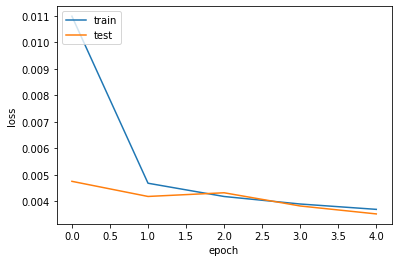

In [58]:
def plot_history(model_history,keys):
    m,val_m = keys
    plt.plot(model_history.history[m])
    plt.plot(model_history.history[val_m])
    plt.ylabel(m)
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

plot_history(hist,['loss','val_loss'])

In [59]:
from tensorflow.keras.losses import MeanSquaredError

y_true = x_test
y_pred = model.predict(x_test_blured)

mse = MeanSquaredError()
mse(y_true, y_pred).numpy()

#0.0023

#0.0041738243220982366
#0.004219622105503972
#0.00404854369862134
#0.003909846398674108
#0.00379532259022029
#0.003393252
#0.0026358136

0.0035615738

Original Images


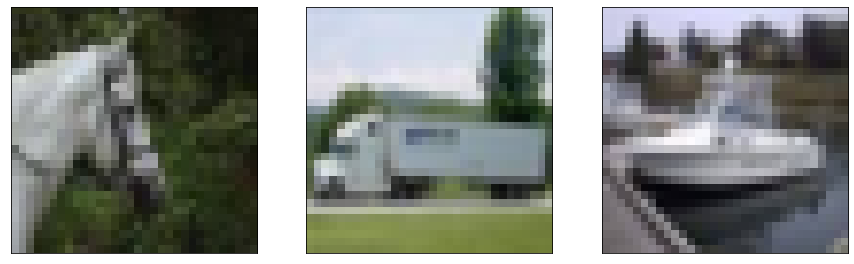

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Blurred Images


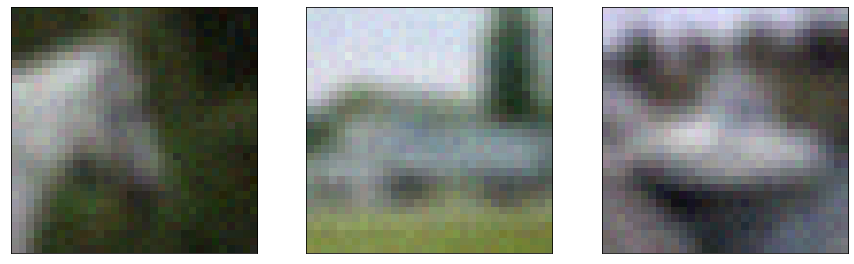

Predicted Images


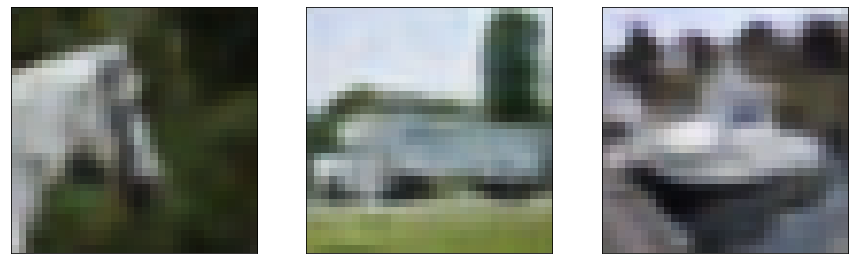

In [24]:
#utility function to pick samples to be tested

def get_samples(arr, n):
    temp = random.sample(range(len(arr)), n)
    result = arr[temp]
    return result, temp

num = 3
figsize = 15
org, temp = get_samples(x_test, num)
blur = x_test_blured[temp]
preds = model.predict(blur.reshape(-1, 32, 32, 3))
#plotting results
plt.figure(figsize = (figsize, figsize))
print('Original Images')
for i in range(num):
    plt.subplot(1, num, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(org[i])
plt.show()
plt.figure(figsize = (figsize, figsize))
print('Blurred Images')
for i in range(num):
    plt.subplot(1, num, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(blur[i])
plt.show()
plt.figure(figsize = (figsize, figsize))
print('Predicted Images')
for i in range(num):
    plt.subplot(1, num, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(preds[i])
plt.show()